**Import library yang dibutuhkan**

In [ ]:
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import time

from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [ ]:
#Dataset
#Versi dataset asli yang digunakan oleh Ahmad dkk ditemukan di https://figshare.com/articles/dataset/Survival_analysis_of_heart_failure_patients_A_case_study/5227684
#Versi yang digunakan pada percobaan ini diambil dari https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

drive.mount('/drive', force_remount=True)
df = pd.read_csv(
    "/drive/My Drive/Colab Notebooks/Data/heart_failure_clinical_records_dataset.csv")


Mounted at /drive


**Preprocessing: Normalisasi & Pemisahan Data Training-Testing**

In [ ]:
features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']

#Separating out the features
dataX = df.loc[:, features].values

#data scaling 
dataX = StandardScaler().fit_transform(dataX)
dataY = df['DEATH_EVENT'].values.tolist()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    dataX,
    dataY,
    test_size=0.30,
    random_state=42,
    stratify=dataY
)
print("Jumlah Data Training",len(Y_train))
print("Jumlah Data Testing",len(Y_test))
#print("Fitur (Training)",X_train)
#print("Target (Training)",Y_train)

Jumlah Data Training 209
Jumlah Data Testing 90


**Inisialisasi Bobot dan variabel yang lain**

In [ ]:
# jumlah neuron pada input layer
jml_neuron_in = len(X_train[0])
#print(jml_neuron_in)

# jumlah neuron pada hidden layer
jml_neuron_hid = 5

# jumlah neuron pada output layer
jml_neuron_out = 1

#panjang array bobot/ weight
ukuran_w = jml_neuron_in * jml_neuron_hid + jml_neuron_hid * jml_neuron_out

#inisialisasi bobot (array) dengan bilangan random -1 hingga 1
random.seed(1)
w =  [(random.randrange(-24,24)/120) for x in range(ukuran_w)]

#delta w
dw =  [0 for x in range(ukuran_w)]

#panjang array theta
ukuran_theta = jml_neuron_hid + jml_neuron_out

#inisialisasi theta (arrray) dengan bilangan random -1 hingga 1
random.seed(2)
Theta =  [(random.randrange(-24,24)/120) for x in range(ukuran_theta)]
#print(Theta)

#delta theta
dTheta =  [0 for x in range(ukuran_theta)]

#alpha = learning rate
alpha = 0.1

#beta = momentum constant
beta = 0.95

#inisialisasi output aktual Y dan error e
e = [0 for x in range(len(Y_train))]

**Fungsi sigmoid**

In [ ]:
def sigmoid(gamma):
  z = 1/(1 + math.exp(-(gamma)))
  #z = math.exp(gamma)/(math.exp(gamma)+1)
  return z 

  #if gamma < 0:
  #  return 1 - 1/(1 + math.exp(gamma))
  #else:
  #  return 1/(1 + math.exp(-gamma))

**Training satu epoch**

In [ ]:
def train(input, desired_output):
  #inisialisasi real output
  Y = [0 for x in range(len(input))]

  #y_hid = output hidden layer  
  y_hid = [0 for x in range(jml_neuron_hid)]

  #jumlah_input = 1
  jumlah_input = len(input)

  #Iterasi per data 
  for i in range(jumlah_input):

    # Hitung output pada hidden layer   
    iw = 0
    sum_weight=[0 for x in range(jml_neuron_hid)]
    for j in range(jml_neuron_hid):
      for k in range(jml_neuron_in):    
        sum_weight[j] += input[i][k]*w[iw]
        iw+=1

    for j in range(jml_neuron_hid):    
      #y_hid = output hidden layer     
      y_hid[j] = sigmoid(sum_weight[j] - Theta[j])
      
    
    # Hitung nilai output pada output layer 
    # iw_hid merupakan indek pertama dari bobot pada hidden - output layer
    iw_hid = iw
    sum_weight2 = 0
    for j in range(jml_neuron_hid):
        sum_weight2 += y_hid[j] * w[iw_hid+j]       

    
    y_out = sigmoid(sum_weight2 - Theta[len(Theta)-1])
  
    Y[i] = y_out
    e[i] = desired_output[i]-Y[i]

    #hitung delta
    delta_out = y_out * (1-y_out) * e[i]
    delta = [0 for x in range(jml_neuron_hid)]
    for j in range(jml_neuron_hid):
      delta[j] = y_hid[j] * (1-y_hid[j]) * delta_out * w[iw_hid+j]

    #hitung bobot baru hidden layer
    for j in range(jml_neuron_hid):
        w[iw_hid + j] = w[iw_hid + j] + alpha * y_hid[j] * delta_out + beta * dw[iw_hid + j]  
    
    Theta[len(Theta) - 1] = Theta[len(Theta) - 1] + alpha * (-1) * delta_out + beta * dTheta[len(dTheta) - 1]   
    
    #hitung bobot baru input
    iw = 0
    for j in range(jml_neuron_hid):
      for k in range(jml_neuron_in):
        w[iw]=w[iw] + alpha * input[i][k] * delta[j] + beta * dw[iw]
        iw+=1

    #print('len(Theta):',len(Theta))
    for j in range(jml_neuron_hid):  
      Theta[j] = Theta[j] + alpha*(-1) * delta[j] + beta * dTheta[j]
      #print('n:',n)

    #hitung dw   
    for j in range(jml_neuron_hid):
      dw[iw_hid+j] = alpha * y_hid[j]*delta_out
    
    dTheta[len(dTheta) - 1] = alpha*(-1)*delta_out

    iw = 0
    for j in range(jml_neuron_hid):
      for k in range(jml_neuron_in):
        dw[iw]= alpha * input[i][k] * delta[j]
        iw+=1
    
    for j in range(jml_neuron_hid):  
      dTheta[j] = alpha*(-1) * delta[j] 
  
  return Y
    

**Testing**

In [ ]:
def test(input): 
  Y = [0 for x in range(len(input))]
  #jml_neuron = jml_neuron_hid + jml_neuron_out
  y_hid = [0 for x in range(jml_neuron_hid)]

  #jumlah_input = 1
  jumlah_input = len(input)
  for i in range(jumlah_input):

    # Hitung output pada hidden layer   
    iw = 0
    sum_weight=[0 for x in range(jml_neuron_hid)]
    for j in range(jml_neuron_hid):
      for k in range(jml_neuron_in):    
        sum_weight[j] += input[i][k]*w[iw]
        iw+=1

    for j in range(jml_neuron_hid):    
      #y_hid = output hidden layer     
      y_hid[j] = sigmoid(sum_weight[j] - Theta[j])
      
    # Hitung nilai output pada output layer 
    #iw_hid merupakan indek pertama dari bobot pada hidden - output layer
    iw_hid = iw
    sum_weight2 = 0
    for j in range(jml_neuron_hid):
        sum_weight2 += y_hid[j] * w[iw_hid+j]       

    y_out = sigmoid(sum_weight2 - Theta[len(Theta)-1])
    Y[i] = y_out


  return Y

**Iterasi per epoch**

In [ ]:
mselist = list()
time_complete = 0
real_output=[]
for p in range(1000):
    start_time = time.time()
    real_output = train(X_train,Y_train)

    print("Epoch:", (p+1), " Acc:",accuracy_score(Y_train, [round(num,0) for num in real_output])," t:", (time.time() - start_time),"s")
    time_complete += (time.time() - start_time)    

    mse = 0
    for i in range(len(e)):
      mse += e[i]**2
    mse=mse/len(e)
    print(len(e))
    mselist.append(mse)

#w


Epoch: 1  Acc: 0.6698564593301436  t: 0.03800463676452637 s
209
Epoch: 2  Acc: 0.6794258373205742  t: 0.038123369216918945 s
209
Epoch: 3  Acc: 0.6842105263157895  t: 0.03760814666748047 s
209
Epoch: 4  Acc: 0.7416267942583732  t: 0.03955841064453125 s
209
Epoch: 5  Acc: 0.8229665071770335  t: 0.04580068588256836 s
209
Epoch: 6  Acc: 0.8421052631578947  t: 0.04634428024291992 s
209
Epoch: 7  Acc: 0.8516746411483254  t: 0.04351949691772461 s
209
Epoch: 8  Acc: 0.8516746411483254  t: 0.03804922103881836 s
209
Epoch: 9  Acc: 0.84688995215311  t: 0.03899788856506348 s
209
Epoch: 10  Acc: 0.84688995215311  t: 0.0388636589050293 s
209
Epoch: 11  Acc: 0.8516746411483254  t: 0.039272308349609375 s
209
Epoch: 12  Acc: 0.8516746411483254  t: 0.039229393005371094 s
209
Epoch: 13  Acc: 0.8516746411483254  t: 0.039813995361328125 s
209
Epoch: 14  Acc: 0.8516746411483254  t: 0.03959536552429199 s
209
Epoch: 15  Acc: 0.8516746411483254  t: 0.0411226749420166 s
209
Epoch: 16  Acc: 0.8516746411483254  

**Menampilkan hasil Training**


In [ ]:
print("Time:",time_complete,"s")
print("mse:",mselist)
print("Real Output   :",[int(round(num,0)) for num in real_output])
print("Desired Output:",Y_train)
print("Weight:",w)
print("Acc:",accuracy_score(Y_train, [round(num,0) for num in real_output]))
print("P:",precision_score(Y_train, [round(num,0) for num in real_output]))
print("R:",recall_score(Y_train, [round(num,0) for num in real_output]))
#print("f1:",f1_score(Y_train, [round(num,0) for num in real_output]))

Time: 40.88333034515381 s
mse: [0.22199569383930673, 0.2109175969081278, 0.1920672069518158, 0.16392736901325544, 0.1417583965859722, 0.13020054420046667, 0.12453608804223937, 0.12152612057000431, 0.11976470971590288, 0.11863271284689518, 0.11783305878287749, 0.1172124425017132, 0.11668742099197804, 0.11621052733603805, 0.1157534658006597, 0.1152983446984296, 0.11483298508817885, 0.11434842401161992, 0.1138376734909253, 0.11329526045722729, 0.11271731189561544, 0.11210206067627668, 0.11145064726506879, 0.11076792864333967, 0.11006265773558974, 0.10934624422334915, 0.108630118260753, 0.1079231450439772, 0.10723064669908124, 0.10655505555738025, 0.10589712524150198, 0.1052568638959821, 0.1046340025406434, 0.10402815004690548, 0.1034388204815201, 0.10286544459328484, 0.1023074050429144, 0.10176409329262874, 0.10123497070630923, 0.10071961637834381, 0.10021775076081575, 0.09972923217265191, 0.09925403012617584, 0.09879218380290827, 0.09834375549514557, 0.09790878769889344, 0.09748726971553

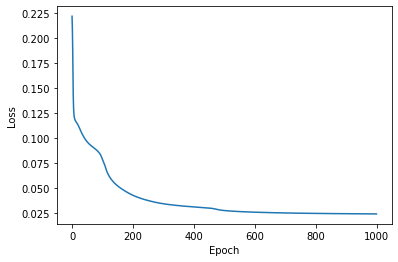

In [ ]:
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(mselist)

**Menampilkan hasil Testing**

In [ ]:
real_output_test = test(X_test)
print("   Real Output:",[int(round(num,2)) for num in real_output_test])
print("Desired Output:",Y_test)

print("Acc:",accuracy_score(Y_test, [round(num,0) for num in real_output_test]))
print("P:",precision_score(Y_test, [round(num,0) for num in real_output_test]))
print("R:",recall_score(Y_test, [round(num,0) for num in real_output_test]))
#print("f1:",f1_score(Y_test, [round(num,0) for num in real_output_test]))

   Real Output: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Desired Output: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Acc: 0.8222222222222222
P: 0.7241379310344828
R: 0.7241379310344828
